#[01] Data & Tokenizer

In [ ]:
%%capture
!pip install datasets
!pip install transformers[torch]

In [ ]:
from datasets import load_dataset
# possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset('kde4', lang1='en', lang2='fr')
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [ ]:
small = data['train'].shuffle(seed=42).select(range(1_000))
split = small.train_test_split(seed=42)

split['train'][0]

{'id': '169005',
 'translation': {'en': '& Reduce Tree', 'fr': "& Refermer l' arborescence"}}

In [ ]:
from transformers import AutoTokenizer

checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']

en, fr

('You can either pick a file or enter its name in the Location: box.',
 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.')

In [ ]:
inputs = tokenizer(en)
inputs

{'input_ids': [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
with tokenizer.as_target_tokenizer():
    targets = tokenizer(fr)
targets

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [344, 1069, 345, 4094, 34, 2428, 345, 9315, 113, 689, 31, 8, 1283, 5, 1470, 21708, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Vous',
 '▁pouvez',
 '▁soit',
 '▁choisir',
 '▁un',
 '▁fichier',
 '▁soit',
 '▁saisir',
 '▁son',
 '▁nom',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁texte',
 '▁Emplacement',
 '.',
 '</s>']

In [ ]:
# wrong language
bad_targets = tokenizer(fr)
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Vous',
 '▁pouvez',
 '▁soit',
 '▁choisir',
 '▁un',
 '▁fichier',
 '▁soit',
 '▁saisir',
 '▁son',
 '▁nom',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁texte',
 '▁Emplacement',
 '.',
 '</s>']

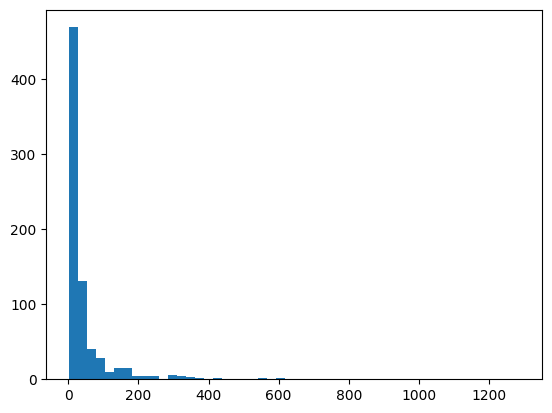

In [ ]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

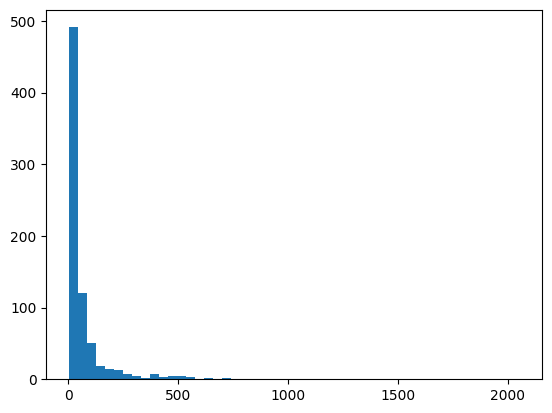

In [ ]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

In [ ]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
    inputs = [x['en'] for x in batch['translation']]
    targets = [x['fr'] for x in batch['translation']]

    tokenized_inputs = tokenizer(
        inputs, max_length=max_input_len, truncation=True
    )

    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(
            targets, max_length=max_target_len, truncation=True
        )

    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    return tokenized_inputs

In [ ]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
[tokenized_datasets['train'][i] for i in range(1, 3)]

[{'input_ids': [526, 3261, 0],
  'attention_mask': [1, 1, 1],
  'labels': [526, 3261, 0]},
 {'input_ids': [3492,
   3070,
   6443,
   37,
   443,
   61,
   32,
   317,
   2203,
   4824,
   514,
   1807,
   971,
   4,
   4124,
   3,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [34023,
   5,
   3948,
   5,
   372,
   402,
   38492,
   350,
   823,
   95,
   13439,
   2,
   25985,
   14,
   6,
   3996,
   3,
   0]}]

In [ ]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
batch['labels']

tensor([[  526,  3261,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
        [34023,     5,  3948,     5,   372,   402, 38492,   350,   823,    95,
         13439,     2, 25985,    14,     6,  3996,     3,     0]])

In [ ]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from previous words!
batch["decoder_input_ids"]

tensor([[59513,   526,  3261,     0, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513],
        [59513, 34023,     5,  3948,     5,   372,   402, 38492,   350,   823,
            95, 13439,     2, 25985,    14,     6,  3996,     3]])

In [ ]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch['decoder_input_ids'][0])

['<pad>',
 '▁K',
 'DE',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch['labels'][0])

['▁K',
 'DE',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [ ]:
split['train'][1]

{'id': '47571', 'translation': {'en': 'KDE', 'fr': 'KDE'}}

In [ ]:
%%capture
!pip install sacrebleu bert-score

In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

<ipython-input-28-ec0ba0363219>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


The repository for sacrebleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sacrebleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for bertscore contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bertscore.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
# targets must be in a list - as you recall, for bleu there can be multiple
# acceptable reference translations
bleu_metric.compute(predictions=["I love cats"], references=[['I love cats']])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [ ]:
s = "Marina is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [ ]:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en'
)

{'precision': [0.9803368449211121],
 'recall': [0.9803368449211121],
 'f1': [0.9803368449211121],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.2)'}

In [ ]:
import numpy as np

def compute_metrics(preds_and_labels):
    # preds are not logits, but token ids
    preds, labels = preds_and_labels

    # convert predictions into words
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # for any -100 label, replace with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # convert labels into words
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # get rid of extraneous whitespace
    # and also, put targets into lists
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu = bleu_metric.compute(
        predictions=decoded_preds, refernces=decoded_labels
    )
    bert_score = bert_metric.compute(
        predictrions=decoded_preds, references=decoded_labels, lang='fr'
    )

    return {"bleu" : bleu["score"], "bert_score" : np.mean(bert_score['f1'])}

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    "finetuned-model",
    eval_strategy="no",
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=72, training_loss=1.5122517479790583, metrics={'train_runtime': 18.6672, 'train_samples_per_second': 120.532, 'train_steps_per_second': 3.857, 'total_flos': 51206128533504.0, 'train_loss': 1.5122517479790583, 'epoch': 3.0})

In [ ]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

TypeError: 'NoneType' object is not iterable

In [ ]:
trainer.save_model("my_saved_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}


In [ ]:
from transformers import pipeline

translator = pipeline("translation", model="my_saved_model", device=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]